# Semi-Supervised Anomaly Detection Survey

We explore here some anomaly detection techniques, providing some simple intuition about how they work and what are their main advantages and disadvantages. This work is loosely bases on a [survey produced by Chandola et al `(`2009`)`](https://www.vs.inf.ethz.ch/edu/HS2011/CPS/papers/chandola09_anomaly-detection-survey.pdf), but it does not intend to cover all the techniques approached in their studies. We will begin describing what is an anomaly and what are its types, following with the challenges imposed by the mains characteristics of the anomaly detection problem.
Then, we will describe the nature of the dataset used in this work.

Although the dataset here considerer is specific to one kind of anomaly detection application, namely, fraud detection, we will treat it as if it was more general, not limiting ourself to the techniques recommended for the dataset we have. Our intention is to provide a practical survey of how some of the main anomaly detection techniques could be implemented, even if they are not tailored for fraud detection. Nonetheless, we will discuss when some method should be preferred, and in the process, justify why some methods yield better results than other in our particular case.

## What is an anomaly
"Anomalies are patterns in data that do not conform to a well defined notion of normal behavior" `(`Chandola et al, 2009`)`. In other words, we can think of them as data coming from another generating process than the one most observations came from. For example, in the image bellow, taken from the survey, we can see the points \( o_1 \) and \(o_2 \) `(`the \( O \) is for outliers`)` isolated from the others. This is a very strong cue that they are anomalies in this two dimensional 

![Image](https://www.researchgate.net/profile/Vipin_Kumar26/publication/220565847/figure/fig1/AS:340388092104705@1458166253261/Fig-1-A-simple-example-of-anomalies-in-a-2-dimensional-data-set.png)

Moreover, points in region \( O_3 \) are also anomalies. Even though they fall in a neighborhood of data, all points in that neighborhood are also anomalies, thus coming from another distribution than those marked with \( N_1 \) and \( N_2 \), where the normal data lies. Anomalies may arise for many reasons. Some examples are credit card frauds, malfunctioning machines or sensors, government corruption, economic crises or sintoms from diseases.

There are three types of anomalies. The first one is point anomaly, that is, "an individual data instance can be considered as anomalous with respect to the rest of data" `(`idem`)`. In the image above, instance \( o_1 \) and \( o_2 \) and all instances in \( O_3 \) are point anomalies since they lie outside the normal regions. As another example, consider credit card transaction data, with information only about amount spent. Then, a transaction to hight compared to the rest for a particular individual is an anomaly.

The second type of anomaly is contextual. In this case, the data must have features regarding some contextual attribute `(`e.g. time, space`)` and some features regarding behavioral attributes. The anomaly is than determined withing a given context. As an example, consider again credit card transactions, but now we have both information about the amount spend and day of the year. Now, a hight amount transaction might be considered normal if it occurred in the week before Christmas, but the same amount transaction in July might be suspicious. We could also have information about the location the client is when performing transactions, and than expect hight amounts if we detect he/she is somewhere far from home, as in a vacation.

The final type of anomaly is collective. In this case, some related data instances are anomalous with respect to the entire data set, but each individual instances may not be considered anomalous. As an example, consider the stock of a retailer. We expect to see its volume fluctuating in time, with low values followed by hight values. However, a low stock for a long period of time is a anomaly. Note that the low volume per se is not an anomaly, but it persistence is. 

Note that the last two types assume some relation among data instances, that is, they are not independent identically distributed `(`i.i.d`)`. In the present work, we have credit card transaction information and time is one of the features, so we could treat this problem as contextual anomaly detection. However, we only have tow days of data, making int almost impossible to determine a useful temporal context. Hence, we will only consider point anomalies techniques to avoid the burden in the extra work of defining a context. Nonetheless, we will keep time as a feature, so in some sense the contextual information will be considered, although no directly modeled.

One final consideration that we need to make is that here only semi-supervised approaches to machine learning will be considered. The other possibility would be to simply use supervised classification methods with some data processing. Since our purpose it to make a anomaly detection survey and not a machine learning clarification survey, we will ignore these techniques. Instead, we refer to the Kaggle website, where most notebooks within the data here consider uses classification supervised approaches for solving the anomaly detection problem. Fore those interesting in supervised anomaly detection,  we recommend a particularly good notebook made by the user joparga3: [In depth skewed data classification](https://www.kaggle.com/joparga3/d/dalpozz/creditcardfraud/in-depth-skewed-data-classif-93-recall-acc-now). We will also use his results as a benchmark `(`and a little bit of his code`)`.

## Challenges

One straightforward approach to anomaly detection would be to simply define a region were the normal data lies and classify anything out of that region as an anomaly. This is most easily said than done and there are some major challenges that often arise in anomaly detection problem:

    - Modeling a normal region that captures all normal behavior is extremely difficult and the boundary between normal an abnormal is often blurred.
    
    - Anomalies might be the result of malicious actions. Than, the malicious adversaries are always trying to adapt to make anomalous observations seem normal.
    
    - The normal behavior can change, and then a current notion of normal might not be valid in the future.
    
    - As we've seen, the notion of an anomaly varies for different application domains, and there is no algorithm that can handle all of them equally well.
    
    - Labeled data for training/validation of models used by anomaly detection techniques is usually a major issue, being either extremely scarce or non existent.
    
    - If the data contains a lot of noise, it is difficult to distinguish noisy instances from anomalies.

In [1]:
import pandas as pd # for data analytics
import numpy as np # for numerical computation
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Dataset

We will use the “Credit Card Fraud Detection”. Following the description provided, "the datasets contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class `(`frauds`)` account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."

As said before, we will consider semi-supervised techiques, were we assume that the training data has labeled instances for only the normal class. In this case, we typically build a model to capture only the normal behavior, tune the model complexity in a labeled validation set and evaluate the model in a equally labeled testing set. More formally, during training, we only model \( P(x) \), that is, the probability of the normal data. At test time, we classify as an anomaly instances that have very low probability. Even when such probability is not directly available in the model, we can, most of the time define a score function proportional to it. Using a validation set, we can tune a threshold for the probability or score below which we will classify the instance as an anomaly. 

For more detailed explanation about the semi-supervised approach, please refer to Andrew Ng's [playlist about anomaly detection](https://www.youtube.com/playlist?list=PLnnr1O8OWc6b_KudrHI0Vcf6sEu6xs9Ky).

Since some of the techniques considered works `(`much`)` better if the features are all Gaussian, we will transform the `Amount` and `Time` features to make them more Gaussian like. Our approach will be to simply take the \( log \) transformation of them. Since some features have zeros, we first add one to \( log \) of zero. 


In [2]:
dataset = pd.read_csv('../input/creditcard.csv')#.drop('Time', axis=1)
dataset = dataset.sample(frac=0.4)
dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)
normal = dataset[dataset['Class'] == 0]

anomaly = dataset[dataset['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(113732, 31)
(191, 31)


To split the data, we will hold 50% of the **normal** instances for training. The rest of the normal data will be equally split among a validation and a test set. The abnormal instances will also be equally spitted between the validation and test set.

In [3]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (90985, 31)
Proportion os anomaly in training set: 0.00

Valid shape:  (11468, 31)
Proportion os anomaly in validation set: 0.01

Test shape:,  (11470, 31)
Proportion os anomaly in test set: 0.01



/tmp/ipykernel_20/2620657688.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
/tmp/ipykernel_20/2620657688.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)


We can see that even after splitting the normal instances in two, the proportion of anomalies in the test and validation set are still very small.

## Evaluation Metrics
Since the data is heavily unbalanced, there is no point in using simple accuracy as evaluation metrics, since a naive model that always predicts a normal class would get more than 99% accuracy. We will thus use precision and recall metrics. As in Sklearn documentations:

"A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Precision ( \( P\) ) is defined as the number of true positives ( \( T_p\) ) over the number of true positives plus the number of false positives (\( F_p\)):

$$P = \frac{T_p}{T_p + F_p}$$

Recall (\( R \)) is defined as the number of true positives (\( T_p \)) over the number of true positives plus the number of false negatives (\( F_n \)):

$$R = \frac{T_p}{T_p + F_n}$$

These quantities are also related to the (\( F_1 \)) score."

Since we are in a scenario of credit card fraud detection, failing to detect a fraud has a higher cost than assigning as fraudulent a normal transaction. Hence, we are more concerned with a high recall metric, as this shows that our system can consistently detect frauds, even if this means getting a few false positives. Nonetheless, we don't want to have a lot of false positives, since there is also a cost in verifying to much transactions assigned as frauds. 

So we can summarize our model's performance in a single metric, we will use the `(`\( F_2 \)`)` score, which places more importance in recall than precision. Formally, it is defined as

$$F_2 = (1+2^2) \frac{P * R}{2^2 * P + R}$$

We will also report confusion matrix for a better understanding of how our errors are distributed.

## Benchmarks

As  a benchmark, we will use joparga3’s notebook. In one of his experiment. As in the time of this writing, the final result was in the following metrics:

$$P = 0.883$$
$$R = 0.619$$
$$F_2 = 0.658$$

## Statistical Anomaly Detection Techniques

As cited in Chandola et al, "an anomaly is an observation which is suspected of being partially or wholly irrelevant because it is not generated by the stochastic model assumed” `(`Anscombe and Guttman 1960`)`. Hence, we assume that *Normal data instances occur in high probability regions of a stochastic model, while anomalies occur in the low probability regions of the stochastic model.* In the statistical model techniques we fit a statistical model and perform statistical inference to decide if an unseen observation comes from the model distribution or not. One advantage of this methods is that we can associate a confidence interval to each prediction, which can help when deciding on a course of action to deal with the anomalies. Another advantages is that if the model is robust to anomalies, it can be used in an unsupervised fashion, without needing any labeled data.

Here we will consider only two statistical anomaly detection techniques.

### Gaussian Model Based

In this technique, we assume that the data comes from a Gaussian distribution. We can fit such a Gaussian using simple *Maximum Likelihood Estimates* `(`MLE`)`. Then, the distance from the mean in standard deviations is the anomaly score for an data instance:

$$\pmb{z}=\frac{|\pmb{x}-\pmb{\bar{x}}|}{\pmb{s}}$$

Where \( \pmb{\bar{x}} \) is the sample mean and \( \pmb{s} \) is the sample variance. We can use a validation set to find an optimal threshold for the score, above which we will consider the instance an anomaly. This is equivalent to finding a hypersphere where the center is the sample mean and the radius is determined by the threshold. Data points outside this sphere will be classified as anomalous. One drawback of this technique is that it does not account for relationships among variables. More technically, this model assumes that that each feature in the data is linear independent from one another and that probabilities of the data can be decomposed as follows

$$P(\pmb{X})=P(\pmb{x_1})*P(\pmb{x_2})*...*P(\pmb{x_d})$$

This would not be a problem if all our variables where principal components extracted from PCA, since they would be linear independent, but as this is not the case, we better account for correlation among features. To do that, we simply use the use the Mahalanobis distance of a test instance \( \pmb{x} \) to the sample mean \( \pmb{\bar{x}} \). So that this score reflects a valid probability distribution, we will fit a full covariance matrix multi-variate normal distribution to the data:

$$\widehat{P(\pmb{x})}=\frac{1}{\sqrt{(2 \pi)^d * det \pmb{S}^{-1}}} * exp \Big(-\frac{1}{2}*(\pmb{x}-\pmb{\bar{x}})^T\pmb{S}^{-1}(\pmb{x}-\pmb{\bar{x}})\Big)$$

were \( \pmb{S} \) is the sample covariance matrix. This fix the problem of assuming linear independence. 

Once again, we use a validation set to determine a threshold for the score, below which we will consider the instance an anomaly. Moreover, we now have the number as bins as an hyper-parameter that we also need to tune.

In [4]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=42)
gmm.fit(train.drop('Class', axis=1).values)
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

13.175066213051178
-385.9748946797245


Now, also using the validation set, we tune a threshold that will be used to classify data as normal or anomalous.

In [5]:
tresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.7364341085271319 78


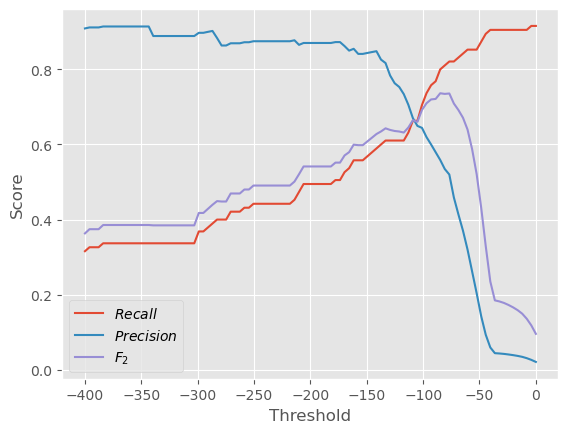

In [6]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Finally, with the trained and tuned model, we produce a final evaluation on the test set.

Final threshold: -84.848485
Test Recall Score: 0.781
Test Precision Score: 0.625
Test F2 Score: 0.744


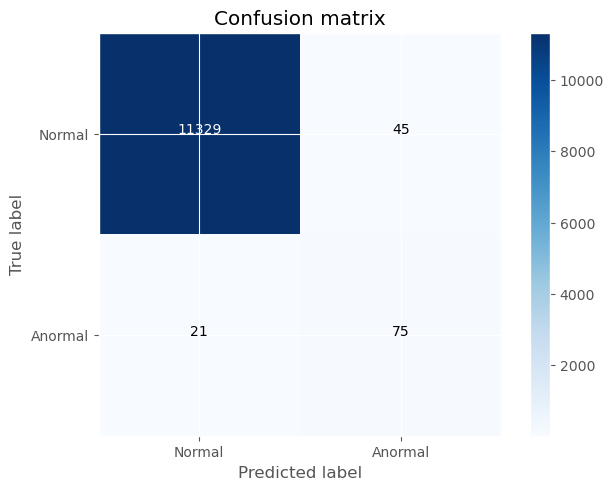

In [7]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

We can see that the \(F_2\) is very good for this mixture of Gaussian model. And beyond being extremely effective, this technique is also very simple. Some disadvantages, as noted by Chandola et al, are that (1) this technique detect anomalies as a by-product of clustering and are not optimized for anomaly detection and `(`2`)` their computational complexity are often bottlenecks for large datasets.

Until now, the techniques we've considered assumed that the data came from a particular distribution or could not capture the relationship between different features in the data. We will now turn our attention to methods that have the potential to universally approximate any probability distributions. This does not mean they are better. As we will see, this extra capacity often yield worse results than the simpler methods, probably because the boundaries produced by them are too complex, causing overfitting.

